### Initial Data Analysis

In [82]:
# !pip install ImageHash

In [83]:
# train_df = pd.read_csv(f'{DATA_DIR}/train.csv')
# train_df.rename(columns={'multiple_diseases': 'multi'}, inplace=True)
# to_drop = ['Train_379', 'Train_782', 'Train_1661'] # dropping repeated/mislabeled samples
# train_df = train_df[~train_df.image_id.isin(to_drop)]
# test_df = pd.read_csv(f'{DATA_DIR}/test.csv')
# print(train_df.head())
# print(test_df.head())
# print(type(train_df.iloc[0]))
# for iterable in train_df.iloc[0].index:
#     print(iterable)

In [84]:
# image display stuff

def disp(img_row):
    img = Image.open(f"{DATA_DIR}/images/{img_row['image_id']}.jpg")
    plt.figure()
    plt.axis('off')
    plt.title(', '.join([f'{lbl}={img_row[lbl]}' for lbl in img_row.index]))
    plt.imshow(img)

In [85]:
rusty_leaves = train_df[train_df['rust'] > 0]
idxs = np.random.choice(len(rusty_leaves), size=10)
for idx in idxs:
    disp(rusty_leaves.iloc[idx])

NameError: name 'train_df' is not defined

In [ ]:
# scabby = train_df[train_df['scab'] > 0]
# idxs = np.random.choice(len(scabby), size=10)
# for idx in idxs:
#     disp(scabby.iloc[idx])

In [ ]:
# helth = train_df[train_df['healthy'] > 0]
# idxs = np.random.choice(len(helth), size=10)
# for idx in idxs:
#     disp(helth.iloc[idx])

In [ ]:
# idxs = np.random.choice(len(test_df), size=10)
# for i in idxs:
#     disp(test_df.iloc[i])

In [86]:
# # looking for similar images (https://github.com/JohannesBuchner/imagehash/blob/master/find_similar_images.py)
# import imagehash
# def find_similar_images(userpaths, hashfunc=imagehash.phash):
#     def is_image(filename):
#         f = filename.lower()
#         return f.endswith(".png") or f.endswith(".jpg") or \
#             f.endswith(".jpeg") or f.endswith(".bmp") or \
#             f.endswith(".gif") or '.jpg' in f or  f.endswith(".svg")
    
#     image_filenames = []
#     for userpath in userpaths:
#         image_filenames += [os.path.join(userpath, path) for path in os.listdir(userpath) if is_image(path)]
#     images = {}
#     problematic = []
#     print("filenames obtained")
#     for img in tqdm(sorted(image_filenames)):
#         try:
#             hash = hashfunc(Image.open(img))
#         except Exception as e:
#             print('Problem:', e, 'with', img)
#             continue
#         if hash in images:
#             print(img, '  already exists as', ' '.join(images[hash]))
#             problematic += [img, *images[hash]]
# #             if 'dupPictures' in img:
# #                 print('rm -v', img)
#         images[hash] = images.get(hash, []) + [img]
#     return problematic
    
# problematic = find_similar_images([f'{DATA_DIR}/images/'])

In [87]:
# # print(problematic)
# pairs = []
# for k in range(0,len(problematic),2):
#     pairs.append( (problematic[k].rsplit('/', 1)[-1], problematic[k+1].rsplit('/', 1)[-1]) )
# print(pairs[-3:])

In [88]:
# idxs = [379, 1173, 782, 592, 815, 1661]
# for i in idxs:
#     disp(train_df.iloc[i])
    
# # seems like we should drop Train_379, Train_782, and Train_1661

In [89]:
# for col in ['healthy', 'multi', 'rust', 'scab']:
#     print(f"{col}, {sum(train_df[col])}")
    
# # data distribution: fairly even except for less multi

## Model Training
Note: This is designed to be runnable even if the data analysis part is not run. As such, there's some code repeat.

In [90]:
from torch.utils.data.dataset import Dataset, Subset
from torch.utils.data import DataLoader
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from sklearn.metrics import roc_auc_score

### Utility Functions

In [91]:
def get_train_data():
    train_df = pd.read_csv(f'{DATA_DIR}/train.csv')
    train_df.rename(columns={'multiple_diseases': 'multi'}, inplace=True)
    to_drop = ['Train_379', 'Train_782', 'Train_1661'] # dropping repeated/mislabeled samples
    train_df = train_df[~train_df.image_id.isin(to_drop)]
    files = [f"{DATA_DIR}/images/{fname}.jpg" for fname in train_df['image_id']]
    labels = train_df.iloc[:, 1:].to_numpy().argmax(axis=1).astype(int)
    return files, labels

In [92]:
def get_test_data():
    test_df = pd.read_csv(f'{DATA_DIR}/test.csv')
    files = [f"{DATA_DIR}/images/{fname}.jpg" for fname in test_df['image_id']]
    return files, None

In [93]:
def get_transforms(train=True):
    transforms = torchvision.transforms.Compose([
            torchvision.transforms.Resize((224, 224)), # change this to some variable later!
            torchvision.transforms.ToTensor()
    ])
    return transforms

In [94]:
def compute_acc(outputs, labels):
    return np.mean(outputs==labels)

def compute_mean_auc(outputs, labels):
    return roc_auc_score(labels, outputs, average='macro', multi_class='ovr')

### Dataset and Dataloader setup

In [95]:
class AppleDataset(Dataset):
    def __init__(self, filepaths, transforms, labels=None):
        self.transforms = transforms
        self.filepaths = filepaths
        self.labels = labels
        
    def __len__(self):
        return len(self.filepaths)
    
    def __getitem__(self, i):
        img = Image.open(self.filepaths[i]).convert('RGB')
        img = self.transforms(img)
        lbl = self.labels[i] if self.labels is not None else None
        return (img, lbl)

In [96]:
# Lightning folds !
class AppleKFoldDataModule(pl.LightningDataModule):
    def __init__(self, k_folds=5):
        self.k_folds = k_folds
        super().__init__()
    
    def setup(self, stage=None):
        transforms = get_transforms()
        train_files, train_labels = get_train_data()
        test_files = get_test_data()
        self.train_dset = AppleDataset(train_files, transforms, labels=train_labels)
        self.test_dset = AppleDataset(test_files, transforms)
    
    def setup_folds(self):
        rng = np.random.default_rng(seed=SEED)
        shuffled_idx = rng.permutation(len(self.train_dset))
        self.splits = np.array_split(shuffled_idx, self.k_folds)
        
    def setup_fold_index(self, i):
        train_idx = np.concatenate(self.splits[:i] + self.splits[i+1:])
        val_idx = self.splits[i]
        self.train_fold = Subset(self.train_dset, train_idx)
        self.val_fold = Subset(self.train_dset, val_idx)
    
    def train_dataloader(self, bsz=32):
        return DataLoader(self.train_fold, batch_size=bsz, shuffle=True) # change batch size for variable
    
    def val_dataloader(self, bsz=32):
        return DataLoader(self.val_fold, batch_size=bsz, shuffle=False)
        
    def test_dataloader(self, bsz=32):
        return DataLoader(self.test_dset, batch_size=bsz, shuffle=False)

### Model(s) Setup

In [97]:
def initialize_base_model(model_name, pretrain=True):
    if model_name == 'resnet-50':
        model = torchvision.models.resnet50(pretrained=pretrain)
        inp_size = 224
        out_size = 1000
        
    return model, inp_size, out_size

In [98]:
class GenericAppleArch(nn.Module):
    def __init__(self, base_model_name='resnet-50', out_classes=4):
        super(GenericAppleArch, self).__init__()
        self.ft_extractor, self.inp_size, out_size = initialize_base_model(base_model_name, pretrain=True)
        self.clfr = nn.Sequential(nn.Linear(out_size, out_classes), nn.Softmax(dim=1))
        
    def forward(self, x):
        x = self.ft_extractor(x)
        out = self.clfr(x)
        return out
    

class AppleModel(pl.LightningModule): #Lightning-fied
    def __init__(self, base_model_name='resnet-50', out_classes=4, lr=1e-5):
        super().__init__()
        self.model = GenericAppleArch(base_model_name=base_model_name, out_classes=out_classes)
        self.lr = lr
        self.save_hyperparameters()
        self.xvals = []
        
    def on_train_epoch_start(self):
        self.train_outputs = []
        self.train_ys = []
    
    def on_validation_epoch_start(self):
        self.val_outputs = []
        self.val_ys = []
        
    def training_step(self, batch, batch_idx):
        x,y = batch
        out = self.model(x)
        loss = F.nll_loss(out, y)
        self.train_outputs += list(out.detach().cpu().numpy())
        self.train_ys += list(y.detach().cpu())
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x,y = batch
        out = self.model(x)
        self.val_outputs += list(out.detach().cpu().numpy())
        self.val_ys += list(y.detach().cpu().numpy())
        loss = F.nll_loss(out, y)
        self.log('val_loss', loss)
    
    def error_check_step(self, batch, batch_idx): # for seeing wrong answers
        x,y = batch
        out = self.model(x)
        self.val_outputs += list(out.detach().cpu().numpy())
        self.val_ys += list(y.detach().cpu().numpy())
        self.xvals += list(x.detach().cpu().numpy())
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        return optimizer
    
    def on_train_epoch_end(self):
        all_outputs = np.array(self.train_outputs)
        all_preds = np.argmax(all_outputs, axis=1)
        all_ys = np.array(self.train_ys)
        epoch_acc = compute_acc(all_preds, all_ys)
        mean_auc = compute_mean_auc(all_outputs, all_ys)
        self.log_dict({'train_acc': epoch_acc, 'train_mean_auc': mean_auc})
        print(f"Train acc={epoch_acc}")
        print(f"Train mean auc={mean_auc}")
    
    def on_validation_epoch_end(self):
        all_outputs = np.array(self.val_outputs)
        all_preds = np.argmax(all_outputs, axis=1)
        all_ys = np.array(self.val_ys)
        epoch_acc = compute_acc(all_preds, all_ys)
        mean_auc = compute_mean_auc(all_outputs, all_ys)
        self.log_dict({'val_acc': epoch_acc, 'val_mean_auc': mean_auc})
        print(f"Val acc={epoch_acc}")
        print(f"Val mean auc={mean_auc}")

### Training Loop

In [100]:
from copy import deepcopy
from datetime import datetime
from pytz import timezone
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

In [101]:
## WANDB
# https://wandb.ai/manan-goel/MNIST/reports/How-to-Integrate-PyTorch-Lightning-with-Weights-Biases--VmlldzoxNjg1ODQ1
import wandb
from pytorch_lightning.loggers import WandbLogger
from kaggle_secrets import UserSecretsClient
import os
user_secrets = UserSecretsClient()
os.environ["WANDB_API_KEY"] = user_secrets.get_secret("wandbKey")

BackendError: Unexpected response from the service. Response: {'errors': ['No user secrets exist for kernel id 27047533 and label wandbKey.'], 'error': {'code': 5, 'details': []}, 'wasSuccessful': False}.

In [ ]:
pl.seed_everything(SEED)
exp_name = "baseline"
try:
    wandb.finish()
except:
    pass
k_models = []
config = {
    'trainer_kwargs': 
        {
            'max_epochs': 30,
            'accelerator': "gpu" if torch.cuda.is_available() else "cpu",
            'default_root_dir': "/kaggle/working/",
            'auto_lr_find': False,
            'log_every_n_steps': 10,
        },
    'model_kwargs':
        {
            'base_model_name': 'resnet-50', 
            'out_classes': 4,
            'lr': 1e-5
        }
}
dm = AppleKFoldDataModule(k_folds=5)
dm.prepare_data()
dm.setup()
dm.setup_folds()
model = AppleModel()
base_state_dict = model.state_dict()
for k in range(dm.k_folds):
    time = datetime.now(timezone('US/Pacific')).strftime("%m_%d-h%H_m%M")
    save_filepath = f"{exp_name}-fold{k+1}of{dm.k_folds}-{time}"
    config['trainer_kwargs']['logger'] = WandbLogger(project="apple-kaggle", entity="waggle", name=f"{exp_name}_fold{k+1}of{dm.k_folds}")
    config['trainer_kwargs']['callbacks'] = [
        EarlyStopping(monitor="val_loss", mode="min"),
        checkpoint_callback = ModelCheckpoint(dirpath="/kaggle/working/", save_top_k=1, monitor="val_loss", filename=save_filepath)
    ]
    trainer = pl.Trainer(**config['trainer_kwargs'])
    dm.setup_fold_index(k)
    model.load_state_dict(base_state_dict)
    trainer.fit(model, datamodule=dm)
    wandb.finish()

In [ ]:
wandb.finish()

## Model Analysis
Testing results of completed models

In [102]:
# input_model_name = "baseline-fold4of5-06_18-h10_m19.ckpt"
iput_model_name = '../input/v65apple/baseline-fold4of5-06_18-h10_m19.ckpt'
# model_path = f"/kaggle/input/appleanalysis/{input_model_name}"
model_path = "/kaggle/input/v65apple/baseline-fold4of5-06_18-h10_m19.ckpt"
ckpt = torch.load(model_path)
# old_model = AppleModel(**ckpt['hyper_parameters'])
old_model = AppleModel.load_from_checkpoint(model_path)

In [135]:
pl.seed_everything(SEED)
dm = AppleKFoldDataModule(k_folds=5)
dm.prepare_data()
dm.setup()
dm.setup_folds()
dm.setup_fold_index(4)
dl = dm.val_dataloader()
print('hey')

old_model.eval()
old_model.on_validation_epoch_start()
for i, (x,y) in enumerate(tqdm(dl)):
    old_model.error_check_step((x,y), i)
    
    

outputs = np.array(old_model.val_outputs)
labels = old_model.val_ys
xvals = old_model.xvals
print(outputs[0])
print(labels[0])
print(xvals[0])

hey


100%|██████████| 12/12 [01:13<00:00,  6.09s/it]

[1.6562686e-04 1.0494308e-03 9.9812037e-01 6.6449179e-04]
2
[[[0.25490198 0.34509805 0.30980393 ... 0.19607843 0.20392157 0.21176471]
  [0.2901961  0.34901962 0.28235295 ... 0.19607843 0.21176471 0.21960784]
  [0.3372549  0.3372549  0.2627451  ... 0.2        0.21568628 0.22352941]
  ...
  [0.23921569 0.27450982 0.31764707 ... 0.7058824  0.7176471  0.7411765 ]
  [0.29803923 0.24705882 0.2784314  ... 0.70980394 0.7254902  0.7490196 ]
  [0.27450982 0.2509804  0.2627451  ... 0.7176471  0.74509805 0.75686276]]

 [[0.43137255 0.49019608 0.45882353 ... 0.27450982 0.2784314  0.28235295]
  [0.45490196 0.49411765 0.44313726 ... 0.27450982 0.28235295 0.2901961 ]
  [0.48235294 0.48235294 0.43137255 ... 0.2784314  0.2901961  0.29803923]
  ...
  [0.2627451  0.17254902 0.2        ... 0.73333335 0.74509805 0.7529412 ]
  [0.35686275 0.1764706  0.17254902 ... 0.7372549  0.7529412  0.7607843 ]
  [0.3647059  0.22745098 0.16078432 ... 0.74509805 0.7529412  0.7647059 ]]

 [[0.12941177 0.16470589 0.16078432 

In [127]:
train_df = pd.read_csv(f'{DATA_DIR}/train.csv')
train_df.rename(columns={'multiple_diseases': 'multi'}, inplace=True)
to_drop = ['Train_379', 'Train_782', 'Train_1661'] # dropping repeated/mislabeled samples
train_df = train_df[~train_df.image_id.isin(to_drop)]

In [137]:
train_df.head()

,image_id,healthy,multi,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


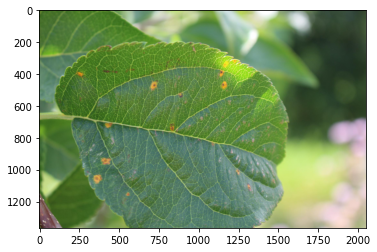

In [126]:

dm.val_fold.indices
img = Image.open(f"{DATA_DIR}/images/Train_1029.jpg")
plt.imshow(img)

In [136]:
val_df.head()

,image_id,healthy,multi,rust,scab
1029,Train_1029,0,0,1,0
1392,Train_1392,1,0,0,0
1643,Train_1643,0,0,0,1
73,Train_73,0,0,0,1
1388,Train_1388,1,0,0,0


In [157]:
val_df = train_df.iloc[dm.val_fold.indices]

val_outputs = np.array(old_model.val_outputs)
val_df.loc[:,'pred_healthy'] = outputs[:,0].round(5)
val_df.loc[:,'pred_multi'] = outputs[:,1].round(5)
val_df.loc[:,'pred_rust'] = outputs[:,2].round(5)
val_df.loc[:,'pred_scab'] = outputs[:,3].round(5)
val_df.head()

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


,image_id,healthy,multi,rust,scab,pred_healthy,pred_multi,pred_rust,pred_scab
1029,Train_1029,0,0,1,0,0.00017,0.00105,0.99812,0.00066
1392,Train_1392,1,0,0,0,0.99988,0.00002,0.00009,0.00002
1643,Train_1643,0,0,0,1,0.00003,0.00032,0.00003,0.99962
73,Train_73,0,0,0,1,0.00000,0.00002,0.00000,0.99998
1388,Train_1388,1,0,0,0,0.99997,0.00001,0.00001,0.00001


In [155]:
val_df['image_id']

1029    Train_1029
1392    Train_1392
1643    Train_1643
73        Train_73
1388    Train_1388
           ...    
1178    Train_1178
577      Train_577
1382    Train_1382
1777    Train_1777
1396    Train_1396
Name: image_id, Length: 363, dtype: object

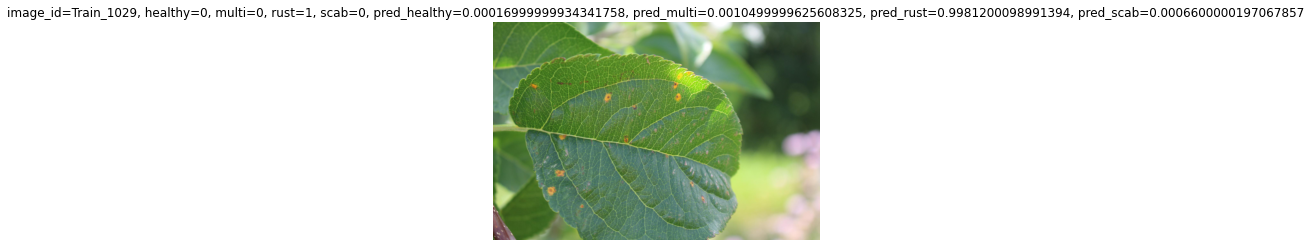

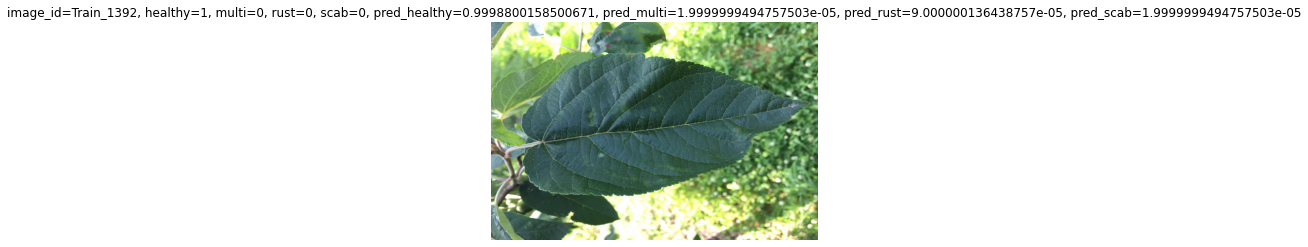

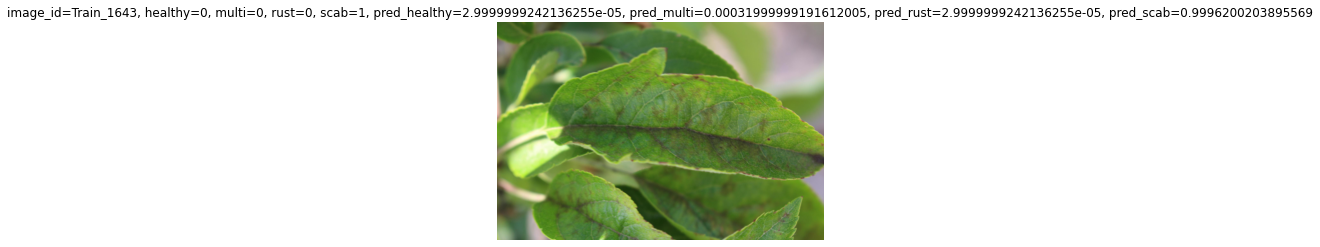

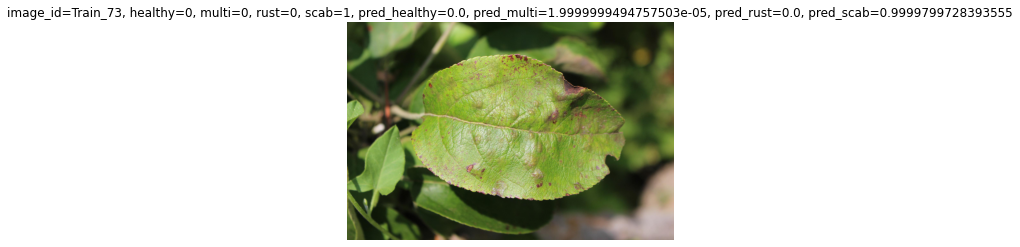

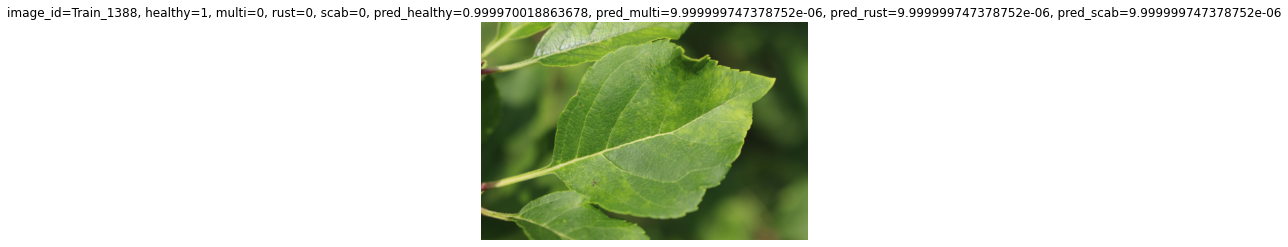

In [158]:
for i in range(5):
    disp(val_df.iloc[i])

2
[1.6562686e-04 1.0494308e-03 9.9812037e-01 6.6449179e-04]
2
(3, 224, 224)


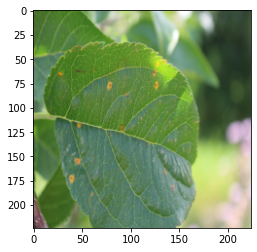

In [106]:
print(np.argmax(outputs[0]))
print(outputs[0])
print(labels[0])
print(xvals[0].shape)
plt.imshow(xvals[0].transpose(1,2,0))

In [107]:
# get all errors
errors = []
for i in range(len(labels)):
    if labels[i] != np.argmax(outputs[i]):
        errors.append((outputs[i], labels[i], xvals[i].transpose(1,2,0)))

In [143]:
def disp(img_row):
    img = Image.open(f"{DATA_DIR}/images/{img_row['image_id']}.jpg")
    plt.figure()
    plt.axis('off')
    plt.title(', '.join([f'{lbl}={img_row[lbl]}' for lbl in img_row.index]))
    plt.imshow(img)

In [108]:
def display_error(ind):
    out, label, img = errors[ind]
    print(out)
    print(label)
    plt.imshow(img)
    plt.show()

[0.00268268 0.02282375 0.41385055 0.560643  ]
1


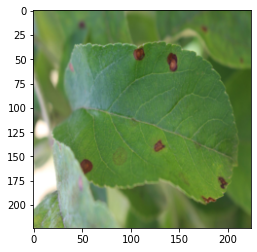

[0.00821231 0.00648998 0.8688344  0.1164633 ]
1


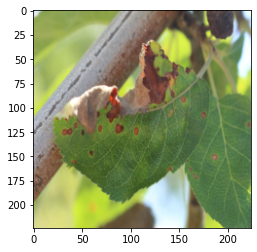

[0.03326283 0.01291891 0.06485622 0.8889621 ]
1


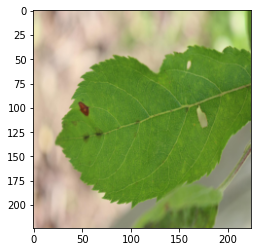

[2.35076914e-06 6.39248174e-05 1.12266525e-05 9.99922514e-01]
1


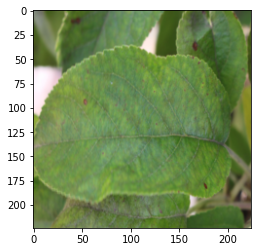

[2.4340705e-04 7.9432027e-03 1.4450742e-03 9.9036837e-01]
1


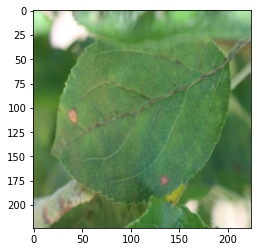

In [109]:
for i in range(len(errors)):
    display_error(i)